In [9]:
import sys
sys.path.append('../') # To import from parent dir
import time
import os
import ast

import pandas as pd
from itertools import chain

from util.GrammarBasedUtil import *

import matplotlib.pyplot as plt

In [10]:
# ---- Define if you want to process a sample Smart RPA Log ----
# Set True if a smartRPALog should be processed
# If false set leno_plus as well
isSmartRPA = True

# ---- Leno Sequential Log ----
# Choose Leno Pluse = True for SR RT ordered first all Student Records afterwars Reimbursement
# If leno_plus = False they are mixed: One SR One RT One SR and so forth
leno_plus = True


#       ####                                        ####
#       ####                                        ####
#       ####                                        ####
#       ####    After Setting the top parameters    ####
#       ####    you can start all cells with the    ####
#       ####    Notebook function ">> Run All".     ####
#       ####                                        ####
#       ####                                        ####
#
#       ####                                        ####
#       ####                                        ####

Setup of Data and reading of necessary files for SmartRPA validation

In [11]:
# ---- Initialize all context parameters that will be used ----
# ---- Define the path in which all files are stored ----
folder_path_smartRPA = "../logs/smartRPA/percentageComparison/"
percentagData_filename = "validationDataPercentage.csv"
log_name_smartRPA = "LenLog_1_1_10_25_2-5_10000.csv"

folder_path_leno = "../logs/leno/"
sep_leno = ";"

# ---- Getting the relevant files from the folder and sorting them into different lists for processing ----
sep_smartrpa = ","
percentageLogs = []

for file in os.listdir(folder_path_smartRPA):
    if file.startswith("LenLog"):
        percentageLogs.append(file)

# Check if data created for percentage based comparison is available
try:
    percentageValData = pd.read_csv(folder_path_smartRPA + percentagData_filename)
    percentageValAvailable = True
except FileNotFoundError as e:
    print(f"Could not read {percentagData_filename} from the folder.\n{e}")
    percentageValAvailable = False

Encoding of unique subsequences - Counting their overall occurances in the log

In [12]:
# Create Standard Based data for both logs, so that all down stream measures look the same

# 1. Dataframe mit Start Index, Length, End_Index
# 2. Context Parameters
#   2.2. All levels initiated
#   2.1. Flatten hierarchy_columns
# 3. Read Files

if isSmartRPA:
    # Note: Read the alignment hints above
    systems = ["category"]
    applications = ["application"]
    uiGroup1 = ["workbook","browser_url","title"]
    uiGroup2 = ["current_worksheet"] 
    uiGroup3 = ["cell_range","cell_range_number"]
    uiElement = ["mouse_coord","tag_category","xpath","event_src_path","event_dest_path","tag_name","tag_title","tag_href",
                "tag_innerText","tab_pinned","tab_audible","tab_muted","window_ingognito","tab_moved_from_index","tab_moved_to_index","id"]
    actions = ["concept:name","eventQual"]
    # ---- Add all hierarchy levels into a list ----
    hierarchy_list_smartrpa = [systems, applications, uiGroup1, uiGroup2, uiGroup3, uiElement, actions]
    hierarchy_columns_smartrpa = list(chain.from_iterable([h for h in hierarchy_list_smartrpa if h]))

    hierarchy_columns = hierarchy_columns_smartrpa
    
    file = pd.read_csv(folder_path_smartRPA + log_name_smartRPA, sep=sep_smartrpa)
    log = symbolize_UILog(file, hierarchy_columns)
    print(f"Processing file: {log_name_smartRPA} with {len(log)} events.")
    comparisonVariables = percentageValData.loc[percentageValData['uiLogName'] == log_name_smartRPA]
    insertSpots = comparisonVariables["motifSpots"]
    parsed_spots = insertSpots.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    insert_spots_flat = [int(i) for sublist in parsed_spots for i in sublist]
    insert_spots_set = set(insert_spots_flat)
    print(f"{len(insert_spots_set)} insertion spots.")
    columns = ["caseid", "start_index", "length", "end_index"]
    ground_truth = pd.DataFrame(columns=columns)
    i = 0
    for insert_spot in insert_spots_set:
        ground_truth.loc[len(ground_truth)] = [i, insert_spot, comparisonVariables["motifLength"].iloc[0], insert_spot + comparisonVariables["motifLength"].iloc[0]]
        i += 1
else:
    systems = []
    applications = ["targetApp"]
    uiGroup1 = ["url","target.workbookName"]
    uiGroup2 = ["target.sheetName"]
    uiElement = ["target.id","target.tagName","target.type","target.name","target.href"]
    actions = ["eventType"]
    hierarchy_list_leno = [applications, uiGroup1, uiGroup2, uiElement, actions]
    # Flatten the hierarchy list and remove empty lists
    hierarchy_columns = list(chain.from_iterable([h for h in hierarchy_list_leno if h]))
    if leno_plus: # Leno Log Sequential
        leno_SR_RT_plus = pd.read_csv(folder_path_leno + "2509_extended_SR_RT_plus.csv", sep=sep_leno)
        leno_SR_RT_plus_ground_truth = pd.read_csv(folder_path_leno + "2509_extended_SR_RT_plus_ground_truth.csv")
        insert_spots_set_SR_RT_plus = leno_SR_RT_plus_ground_truth["start_index"].astype(int).tolist()
        leno_SR_RT_plus_ground_truth["end_index"] = 0
        leno_SR_RT_plus_ground_truth["end_index"] = leno_SR_RT_plus_ground_truth["start_index"] + leno_SR_RT_plus_ground_truth["length"]
        ground_truth = leno_SR_RT_plus_ground_truth
        log = symbolize_UILog(leno_SR_RT_plus, hierarchy_columns)
    else: # Leno Log Parallel
        leno_SR_RT_parallel = pd.read_csv(folder_path_leno + "2509_extended_SR_RT_parallel.csv", sep=sep_leno)
        leno_SR_RT_parallel_ground_truth = pd.read_csv(folder_path_leno + "2509_extended_SR_RT_parallel_ground_truth.csv")
        insert_spots_set_SR_RT_parallel = leno_SR_RT_parallel_ground_truth["start_index"].astype(int).tolist()
        leno_SR_RT_parallel_ground_truth["end_index"] = 0
        leno_SR_RT_parallel_ground_truth["end_index"] = leno_SR_RT_parallel_ground_truth["start_index"] + leno_SR_RT_parallel_ground_truth["length"]
        ground_truth = leno_SR_RT_parallel_ground_truth
        log = symbolize_UILog(leno_SR_RT_parallel, hierarchy_columns)

Processing file: LenLog_1_1_10_25_2-5_10000.csv with 10000 events.
10 insertion spots.


In [13]:
# ---- Time the original implementation ----
encoding_df, symbols, two_gram_df = re_pair(log)
last_entry = len(encoding_df["new_symbol"])-1
last_encoding = encoding_df["new_symbol"].iloc[last_entry]
print("\n Last Encoded Entry: ",last_encoding)
decoded_symbol = re_pair_decode_symbol(last_encoding, encoding_df, printing=True)

346  unique pairs found so far. Level:  1
363  unique pairs found so far. Level:  2
370  unique pairs found so far. Level:  3
373  unique pairs found so far. Level:  4
374  unique pairs found so far. Level:  5

 Last Encoded Entry:  nj
nj → (ng, nh)
  ng → (nc, mz)
    nc → (mn, mp)
      mn → (FAC, a)
        FAC → [base symbol]
        a → (EYT, EYT)
          EYT → [base symbol]
          EYT → [base symbol]
      mp → (g, i)
        g → (EYT, FLL)
          EYT → [base symbol]
          FLL → [base symbol]
        i → (FGI, FAB)
          FGI → [base symbol]
          FAB → [base symbol]
    mz → (mr, d)
      mr → (k, m)
        k → (FAA, FBM)
          FAA → [base symbol]
          FBM → [base symbol]
        m → (FMV, FRH)
          FMV → [base symbol]
          FRH → [base symbol]
      d → (EYT, FGI)
        EYT → [base symbol]
        FGI → [base symbol]
  nh → (na, nb)
    na → (mj, FLL)
      mj → (FMV, r)
        FMV → [base symbol]
        r → (EYT, FAD)
          EYT → [

Exec. Time with loops: 7.240 seconds
6883


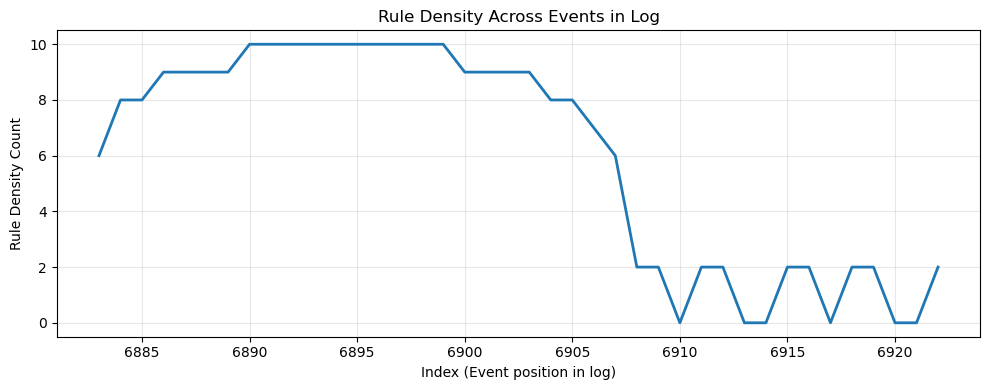

In [14]:
# Initialize the count column
start_time = time.time()
log = generate_density_count(encoding_df, log)
end_time = time.time()
print(f"Exec. Time with loops: {end_time - start_time:.3f} seconds")
motiv = int(ground_truth.iloc[0]["start_index"])
print(motiv)
plot_density_curve(log, range_low=motiv, range_high=motiv+40)

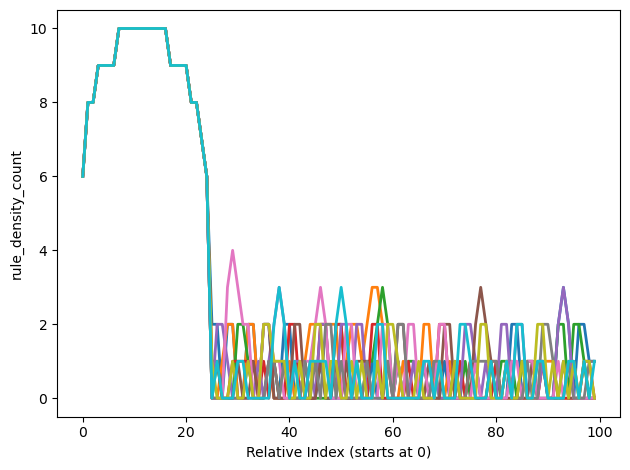

In [15]:
colors = plt.cm.tab10.colors
for i, start in enumerate(ground_truth["start_index"]):
    end = start+100
    y = log.iloc[start:end]["rule_density_count"].to_numpy()
    x = range(len(y))  # all start at 0
    plt.plot(x, y, color=colors[i % len(colors)], linewidth=2, label=f"Range {start}-{end}")

plt.xlabel("Relative Index (starts at 0)")
plt.ylabel("rule_density_count")
plt.tight_layout()
plt.show()

Maximum rule density count: 10
Connected index groups with maximum density:
Menge der Density Groups: 10
Overlap of the density groups and motifs: 10


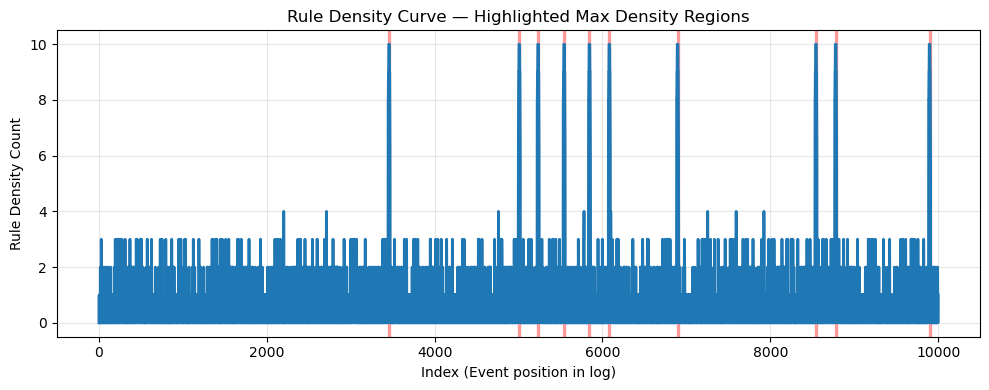

Motif 1: start=3445, end=3469, length=25
Motif 2: start=4997, end=5021, length=25
Motif 3: start=5221, end=5245, length=25
Motif 4: start=5531, end=5555, length=25
Motif 5: start=5833, end=5857, length=25
Motif 6: start=6070, end=6094, length=25
Motif 7: start=6883, end=6907, length=25
Motif 8: start=8532, end=8556, length=25
Motif 9: start=8767, end=8791, length=25
Motif 10: start=9886, end=9910, length=25

----
Longest identified motif length: 25


In [16]:
max_density, max_groups = find_max_density_groups(log,relative_threshold=0.6)

print(f"Maximum rule density count: {max_density}")
print("Connected index groups with maximum density:")
# for g in max_groups:
#    print(f"  {g[0]}–{g[-1]} ({len(g)} elements)")

# >> Wie finden wir jetzt von diesem Punkt aus die richtige Länge an Motifen im Datensatz? 
# Die Punkte haben wir

overlaps = []
for _, row in ground_truth.iterrows():
    s1, e1 = row["start_index"], row["end_index"]
    for g in max_groups:
        s2, e2 = g[0], g[-1]
        if not (e1 < s2 or e2 < s1):  # overlap condition
            overlaps.append({"insert_range": (s1, e1), "density_range": (s2, e2)})

print(f"Menge der Density Groups: {len(max_groups)}")
print(f"Overlap of the density groups and motifs: {len(overlaps)}")

plt.figure(figsize=(10, 4))
plt.plot(log.index, log["rule_density_count"], linewidth=2)
for g in max_groups:
    plt.axvspan(g[0], g[-1], color="red", alpha=0.3)
plt.title("Rule Density Curve — Highlighted Max Density Regions")
plt.xlabel("Index (Event position in log)")
plt.ylabel("Rule Density Count")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# ---- Expanded Density Version ----
# Has to be verified with regard to the OG logs in SmartRPA and Leno
# For Leno it currently produces too short motifs
max_density, groups = find_max_density_groups(log, column="rule_density_count", relative_threshold=0.6)
expanded = expand_density_regions(log, column="rule_density_count", groups=groups, threshold_ratio=0.5)

max_length = 0
for i, (s, e) in enumerate(expanded, 1):
    print(f"Motif {i}: start={s}, end={e}, length={e - s + 1}")
    if max_length < e-s+1:
        max_length = e-s+1

print(f"\n----\nLongest identified motif length: {max_length}")